Este agarra los datos del csv con la matriz de grayscale de cada espectrograma, y se los pasa al modelo de CNN de PyTorch (definido en aux file models.py), los guarda para poder llamarlo sin re-entrenar desde otros archivos

In [ ]:
import os, sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [5]:
# UNCOMMENT THE ONE BEING USED

# NOT NOISE-REDUCED
# df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data.csv'))

# NOISE-REDUCED
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data2.csv'))

In [ ]:
# Extract labels and pixel values
labels = df['label'].values.astype(np.int64)
features = df.drop(columns=['label']).values.astype(np.float32)
features /= 255.0
features = features.reshape(-1, 1, 313, 224)

print("features shape:", features.shape)
print("labels shape:", labels.shape)

In [20]:
import importlib
importlib.reload(models)
importlib.reload(util)

<module 'utils.util' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ChirpID-backend\\utils\\util.py'>

In [ ]:
# Prepare tensors
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

Run to Train

In [18]:
# Run K-Fold training
results = util.k_fold_cross_validation(
    dataset=dataset,
    model_class=models.BirdCNN,
    num_classes=28,
    k_folds=5,
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    aggregate_predictions=True
)


Starting 5-Fold Cross Validation on cuda
Dataset size: 3070

FOLD 1/5
Train size: 2456, Val size: 614


Fold 1 - Epoch 250/250: 100%|██████████| 250/250 [16:41<00:00,  4.01s/epoch, train_acc=0.967, train_loss=0.1025, val_acc=0.801, val_loss=1.3133]


Fold 1 Final - Val Acc: 0.8013, Val Loss: 1.3133

FOLD 2/5
Train size: 2456, Val size: 614


Fold 2 - Epoch 250/250: 100%|██████████| 250/250 [16:53<00:00,  4.05s/epoch, train_acc=0.978, train_loss=0.0642, val_acc=0.806, val_loss=1.3872]


Fold 2 Final - Val Acc: 0.8062, Val Loss: 1.3872

FOLD 3/5
Train size: 2456, Val size: 614


Fold 3 - Epoch 250/250: 100%|██████████| 250/250 [16:52<00:00,  4.05s/epoch, train_acc=0.935, train_loss=0.1891, val_acc=0.718, val_loss=2.1466]


Fold 3 Final - Val Acc: 0.7182, Val Loss: 2.1466

FOLD 4/5
Train size: 2456, Val size: 614


Fold 4 - Epoch 250/250: 100%|██████████| 250/250 [16:26<00:00,  3.95s/epoch, train_acc=0.943, train_loss=0.1697, val_acc=0.741, val_loss=1.7011]


Fold 4 Final - Val Acc: 0.7410, Val Loss: 1.7011

FOLD 5/5
Train size: 2456, Val size: 614


Fold 5 - Epoch 250/250: 100%|██████████| 250/250 [17:00<00:00,  4.08s/epoch, train_acc=0.979, train_loss=0.0604, val_acc=0.782, val_loss=1.7065]


Fold 5 Final - Val Acc: 0.7818, Val Loss: 1.7065


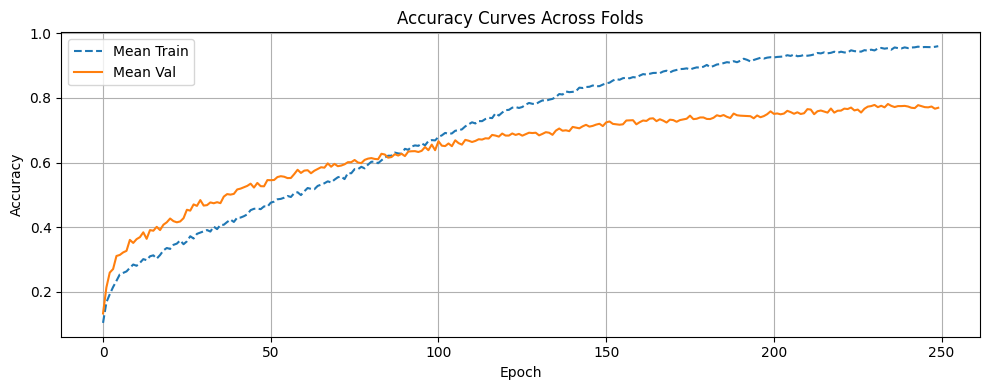

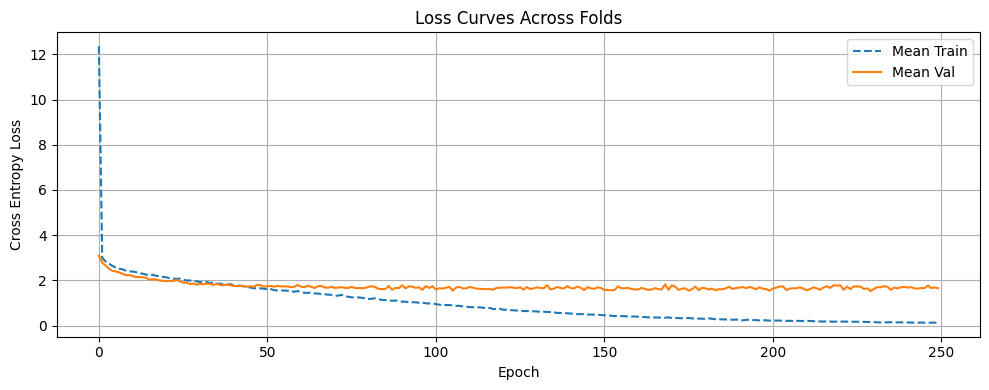

In [ ]:
# Plot accuracy and loss curves
util.plot_mean_curve(results, metric_key='accuracies', title="Accuracy Curves Across Folds", ylabel="Accuracy")
util.plot_mean_curve(results, metric_key='losses', title="Loss Curves Across Folds", ylabel="Cross Entropy Loss")
util.plot_mean_curve(results, metric_key='f1s', title="F1 Score Curves Across Folds", ylabel="Macro F1 Score")

In [ ]:
# Print detailed F1 results
print("F1 Score Results:")
print("="*50)

if 'aggregated_f1' in results['summary']:
    print(f"Aggregated F1 Score: {results['summary']['aggregated_f1']:.4f}")
    
print(f"Mean F1 Score: {results['summary']['mean_val_f1']:.4f} ± {results['summary']['std_val_f1']:.4f}")
print(f"Individual Fold F1 Scores: {[f'{f1:.4f}' for f1 in results['summary']['individual_f1s']]}")

# Show best F1 per fold
print("\nBest F1 per fold:")
for fold_name, fold_data in results['fold_results'].items():
    print(f"{fold_name}: {fold_data['best_val_f1']:.4f}")

In [22]:
# Example: save model from best fold (e.g. fold 3)
best_model_state = results['fold_results']['fold_3']['model_state']
model = models.BirdCNN(num_classes=28).to(device)
model.load_state_dict(best_model_state)
util.save_model(model, "bird_cnn")

Model weights saved to: ..\models\bird_cnn.pth


In [24]:
state = torch.load("../models/bird_cnn.pth", map_location='cpu')
print(type(state))
print(list(state.keys())[:5])  # show first 5 parameter names
print(state[list(state.keys())[0]].shape)  # show shape of first tensor

<class 'collections.OrderedDict'>
['net.0.weight', 'net.0.bias', 'net.1.weight', 'net.1.bias', 'net.1.running_mean']
torch.Size([32, 1, 3, 3])
